In [1]:
from lzt_utils.dataset import LztDataset
from lzt_utils.constants import N_RINGS
from lzt_utils.root import rdf_column_names, rdf_to_pandas, open_vector
from lzt_utils import formulas
import lzt_utils.plotting.pyplot as lplt
import mplhep
import matplotlib.pyplot as plt
import os
from pathlib import Path
import ROOT
import numpy as np
import pandas as pd
ROOT.EnableImplicitMT()
plt.style.use(mplhep.style.ROOT)

In [ ]:
lzt_data = Path('/', 'root', 'ext_data', 'lorenzetti')
datasets_info = {
    'zee-mb-2024-12-08': {'color': 'blue'},
    'jet-mb-2024-12-08': {'color': 'red'}
}
datasets = {}
for name, info in datasets_info.items():
    ds = LztDataset.from_dir(lzt_data/name)
    ds.color = info['color']
    datasets[name] = ds
output_dir = lzt_data / 'profiles' / 'aprendizado-profundo-2024-10-08'
output_dir.mkdir(exist_ok=True, parents=True)
datasets

{'zee-mb-2024-12-08': LztDataset(path=/root/ext_data/lorenzetti/zee-mb-2024-12-08, label=Z -> ee),
 'jet-mb-2024-12-08': LztDataset(path=/root/ext_data/lorenzetti/jet-mb-2024-12-08, label=JF17)}

In [3]:
def ntuple_aggregation(df: pd.DataFrame) -> pd.Series:
    n_objects = len(df)
    if n_objects:
        ordered_idxs = df.index[df['cluster_e'].argsort()][::-1]
        highest_e1 = df.loc[ordered_idxs[0], 'cluster_e']
        highest_e2 = df.loc[ordered_idxs[1], 'cluster_e'] if n_objects > 1 else np.nan
        eta1 = df.loc[ordered_idxs[0], 'el_eta']
        eta2 = df.loc[ordered_idxs[1], 'el_eta'] if n_objects > 1 else np.nan
        phi1 = df.loc[ordered_idxs[0], 'el_phi']
        phi2 = df.loc[ordered_idxs[1], 'el_phi'] if n_objects > 1 else np.nan
    else:
        highest_e1 = np.nan
        highest_e2 = np.nan
        eta1 = np.nan
        eta2 = np.nan
        phi1 = np.nan
        phi2 = np.nan
    return pd.Series({
        'n_objects': n_objects,
        # Plus 1 to account for the event itself
        'n_duplicates': df.duplicated().sum()+1,
        'highest_e1': highest_e1,
        'highest_e2': highest_e2,
        'eta1': eta1,
        'eta2': eta2,
        'phi1': phi1,
        'phi2': phi2
    })

In [3]:
for dataset_name, dataset in datasets.items():
    ntuple_rdf = dataset.get_ntuple_rdf()
    rings_cols, ntuple_rdf = open_vector('rings', N_RINGS, ntuple_rdf)
    column_names = rdf_column_names(ntuple_rdf)
    ntuple_pdf = rdf_to_pandas(ntuple_rdf, [name for name in column_names if name != 'rings'], nrows=-1)
    print(f"DataFrame shape: {ntuple_pdf.shape}")
    for name, dtype in ntuple_pdf.dtypes.items():
        if name.startswith('rings_'): continue
        print(f"{name}: {dtype}")
    dataset.ntuple_pdf = ntuple_pdf
datasets

DataFrame shape: (29764, 143)
cluster_deta: float32
cluster_dphi: float32
cluster_e: float32
cluster_e0: float32
cluster_e1: float32
cluster_e2: float32
cluster_e233: float32
cluster_e237: float32
cluster_e277: float32
cluster_e2tsts1: float32
cluster_e3: float32
cluster_ehad1: float32
cluster_ehad2: float32
cluster_ehad3: float32
cluster_emaxs1: float32
cluster_emaxs2: float32
cluster_eratio: float32
cluster_et: float32
cluster_eta: float32
cluster_etot: float32
cluster_f0: float32
cluster_f1: float32
cluster_f2: float32
cluster_f3: float32
cluster_fracMax: float32
cluster_lambdaCenter: float32
cluster_lateralMom: float32
cluster_longitudinalMom: float32
cluster_phi: float32
cluster_reta: float32
cluster_rhad: float32
cluster_rhad1: float32
cluster_rphi: float32
cluster_secondLambda: float32
cluster_secondR: float32
cluster_weta2: float32
el_fwdLoose: object
el_fwdMedium: object
el_fwdTight: object
el_loose: object
el_medium: object
el_tight: object
el_vloose: object
DataFrame shape: 

{'zee-mb-2024-12-08': LztDataset(path=/root/ext_data/lorenzetti/zee-mb-2024-12-08, label=Z -> ee),
 'jet-mb-2024-12-08': LztDataset(path=/root/ext_data/lorenzetti/jet-mb-2024-12-08, label=JF17)}

In [5]:
for dataset in datasets.values():
    filepath = output_dir / f'{dataset.name}_ntuple_grouped_clusters.parquet'
    if os.path.exists(filepath):
        ntuple_grouped_clusters = pd.read_parquet(filepath)
    else:
        ntuple_grouped_clusters = dataset.ntuple_pdf.groupby('event_number').apply(ntuple_aggregation)
        ntuple_grouped_clusters['deltaR'] = formulas.deltaR(ntuple_grouped_clusters['eta1'].values,
                                                            ntuple_grouped_clusters['phi1'].values,
                                                            ntuple_grouped_clusters['eta2'].values,
                                                            ntuple_grouped_clusters['phi2'].values)
        print(f"DataFrame shape: {ntuple_grouped_clusters.shape}")
        ntuple_grouped_clusters.to_parquet(filepath)
    dataset.ntuple_grouped_clusters = ntuple_grouped_clusters

# All Rings

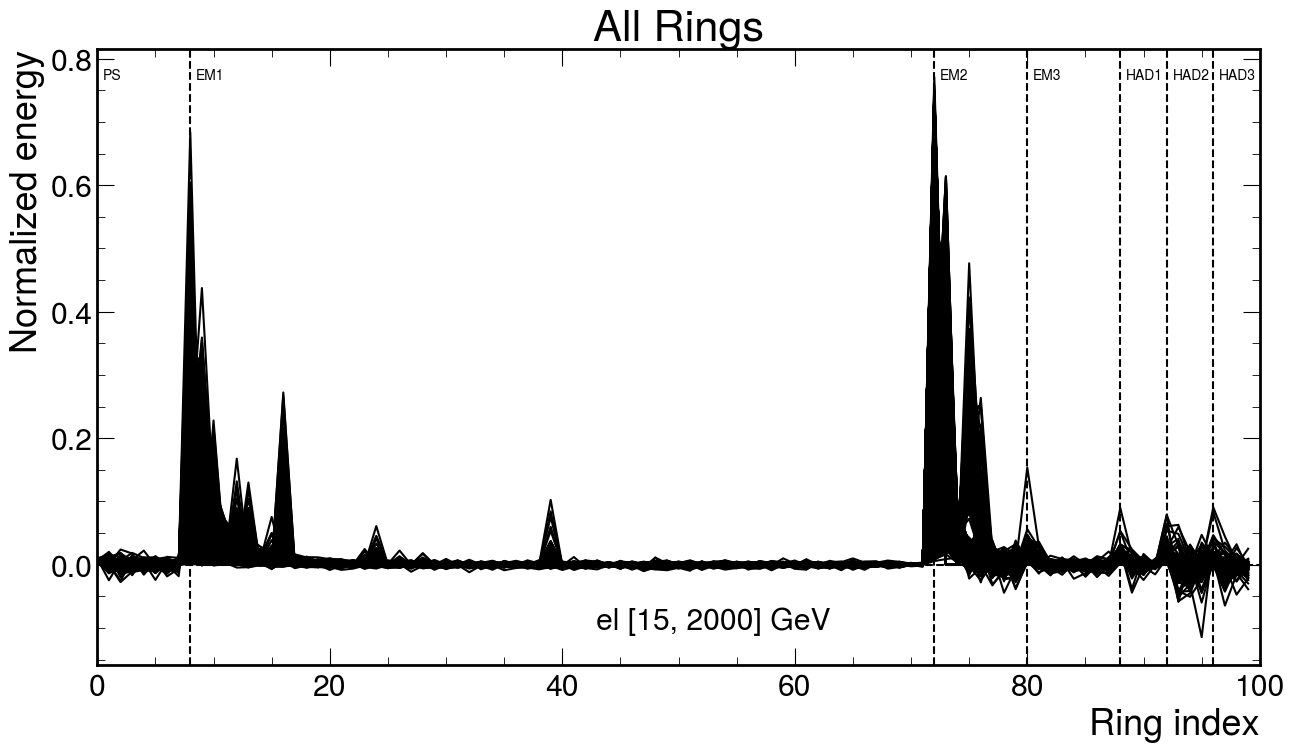

In [46]:
fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(N_RINGS)
lplt.plot_all_rings(ntuple_pdf[rings_cols], ax, normalize=True, plot_kwargs=dict(color='k'))
ax.plot([], [], ' ', label=dataset.label)
ax.legend()
fig.savefig(output_dir/'all_rings.png', bbox_inches='tight', dpi=300)

# Rings Profile

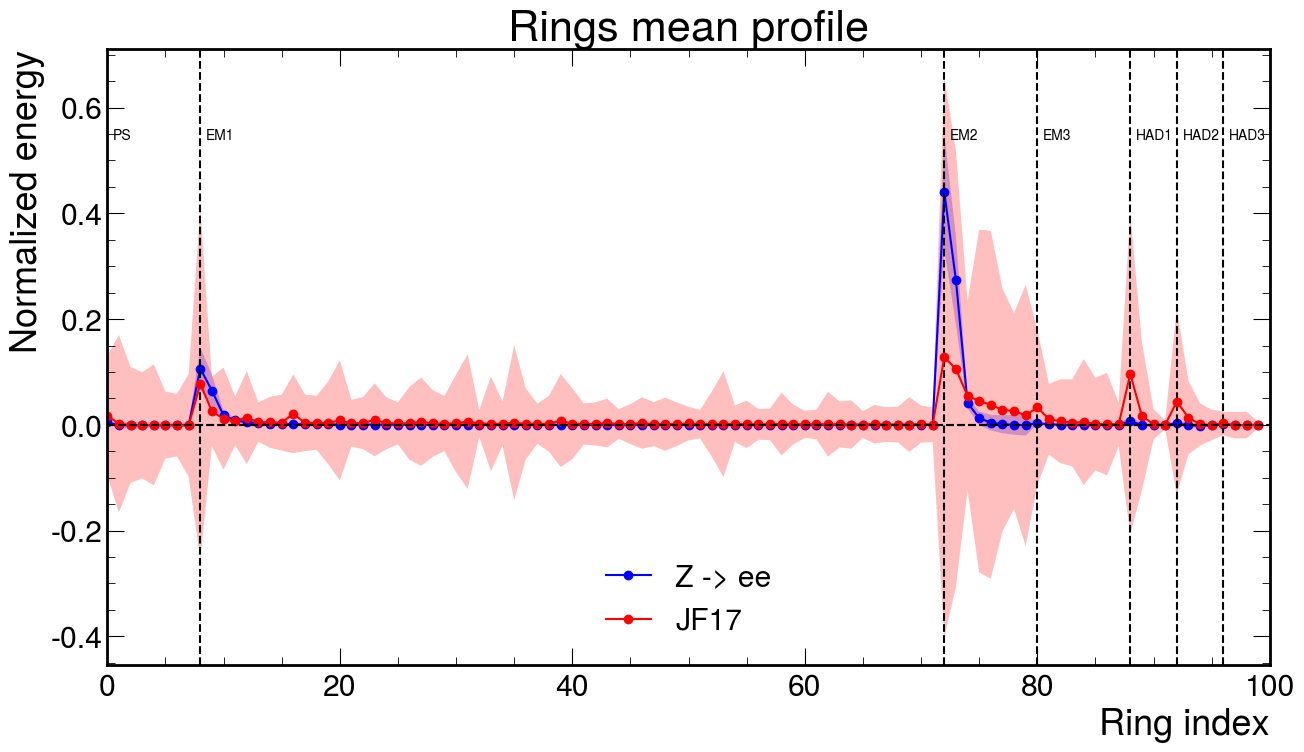

In [4]:
normalize = True
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.plot_rings_profile(ds.ntuple_pdf[rings_cols], ax, normalize=normalize,
                            label=ds.label, add_rings_labels=i==0,
                            color=ds.color)
normalization_str = 'normalized' if normalize else 'not_normalized'
fig.savefig(
    output_dir/f'rings_profile_{normalization_str}.png', bbox_inches='tight', dpi=300)

# $\Delta R$

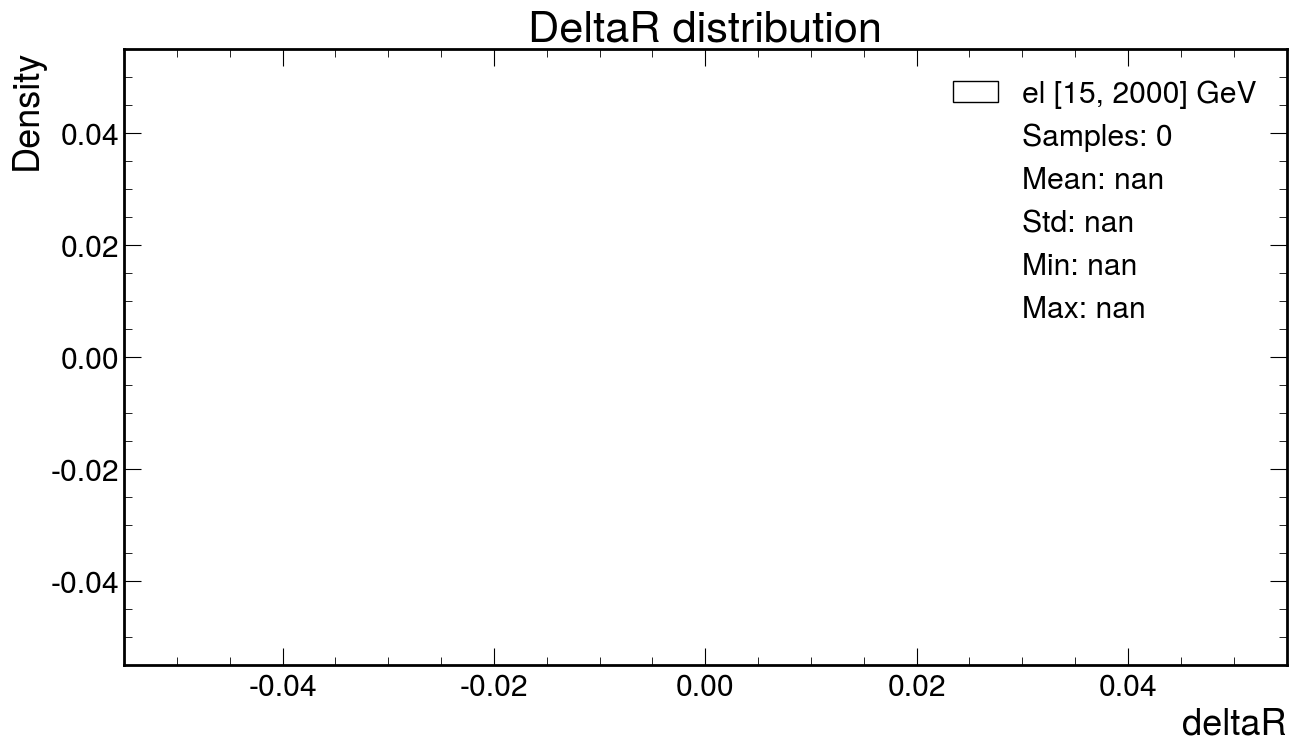

In [48]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_grouped_clusters['deltaR'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel='deltaR',
        ylabel='Density',
        title='DeltaR distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
fig.savefig(output_dir / 'deltaR_distribution.png', bbox_inches='tight', dpi=300)

# Object distribution

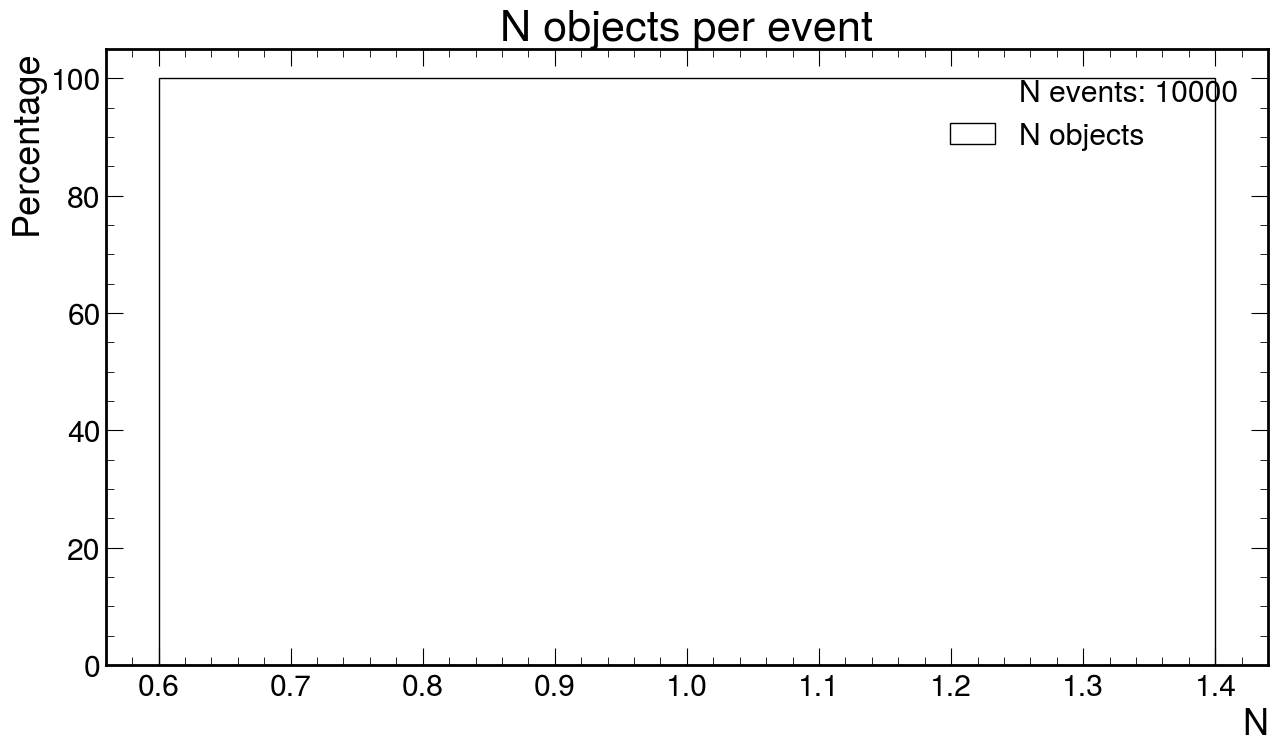

In [49]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.categorical_histplot(
    ntuple_grouped_clusters['n_objects'].dropna(),
    ax=ax,
    metrics=False,
    percentage=True,
    ax_set=dict(
        xlabel='N',
        ylabel='Percentage',
        title='N objects per event',
    ),
    bar_kwargs=dict(
        label='N objects',
        color='w',
        edgecolor='k'
    )
)
ax.plot([], [], ' ', label=f"N events: {len(ntuple_grouped_clusters)}")
ax.legend()
fig.savefig(output_dir/'objects_per_event_distribution.png', bbox_inches='tight', dpi=300)

# Cluster Energy

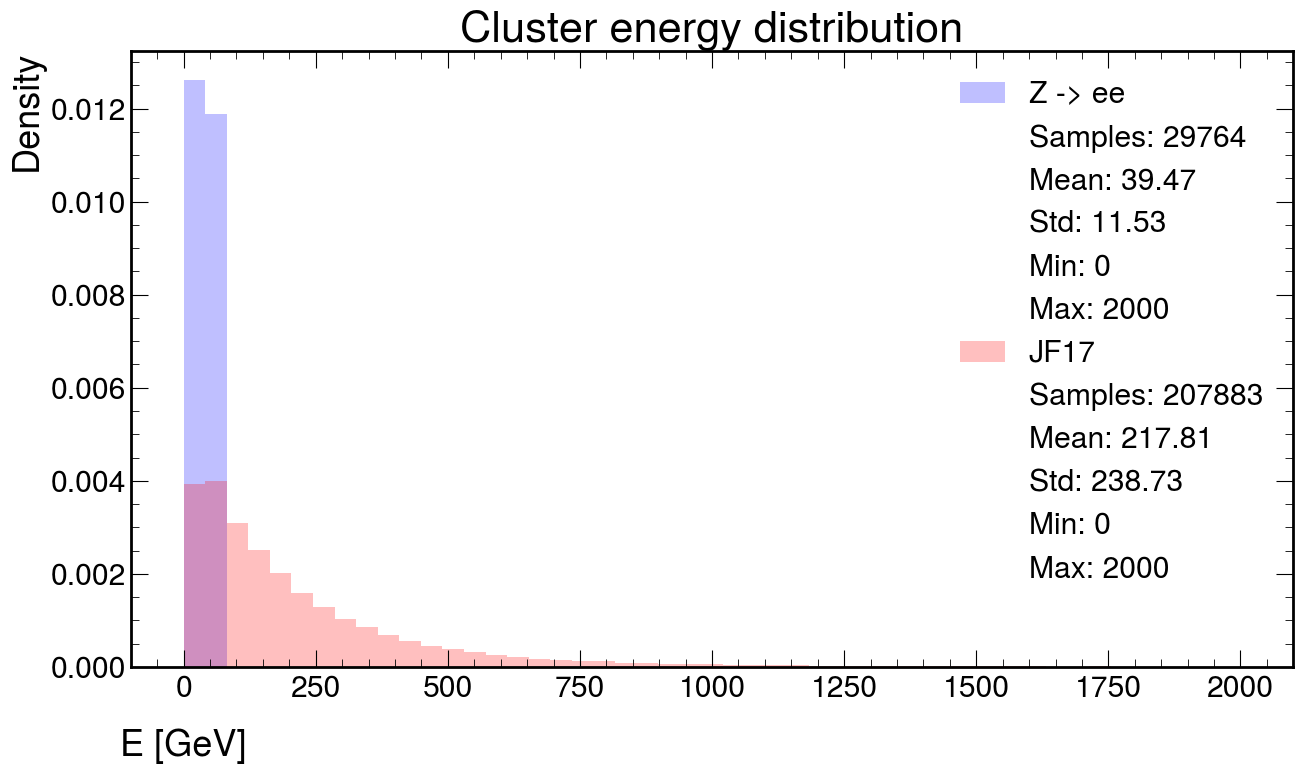

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cluster_e'].dropna()/1000,
        nbins=50,
        ax=ax,
        metrics=True,
        bin_max=2000,
        bin_min=0,
        ax_set=dict(
            xlabel='E [GeV]',
            ylabel='Density',
            title='Cluster energy distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(output_dir/'cluster_e_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $E_T$

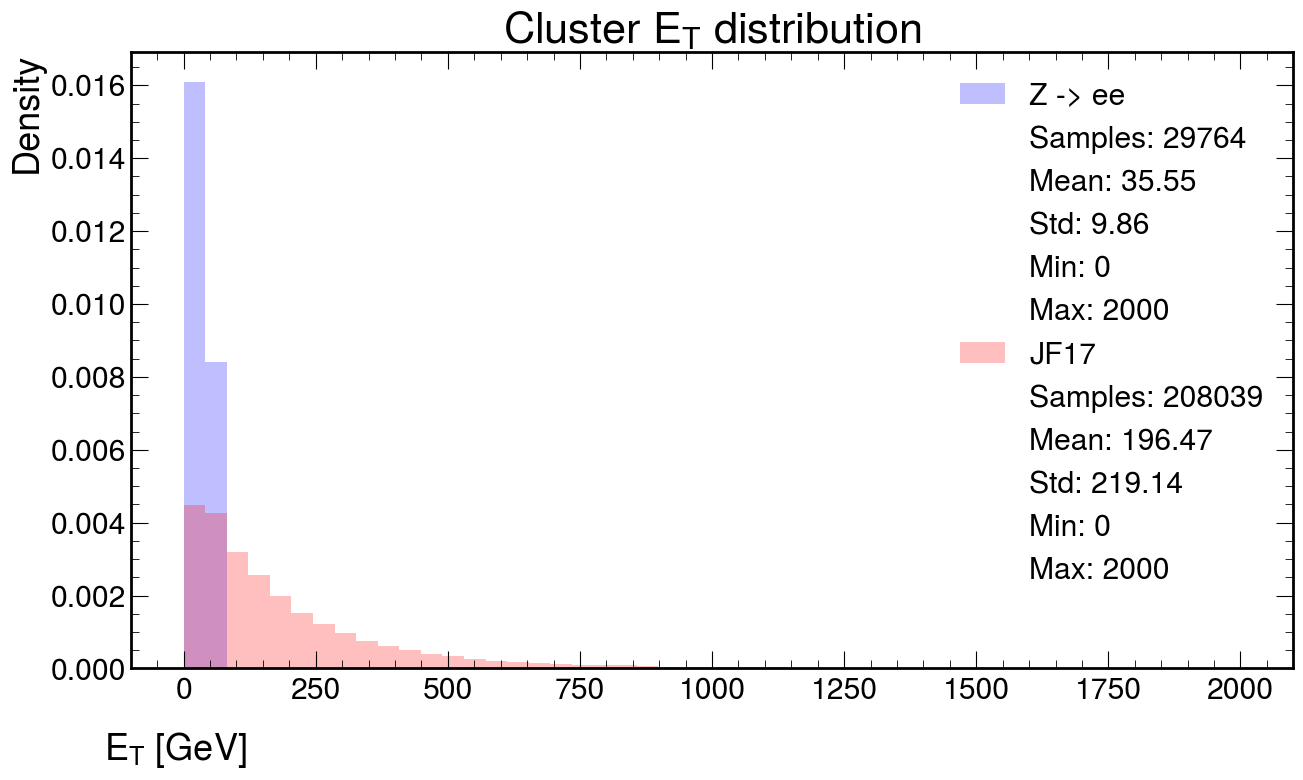

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cluster_et'].dropna()/1000,
        nbins=50,
        ax=ax,
        metrics=True,
        bin_max=2000,
        bin_min=0,
        ax_set=dict(
            xlabel=r'$E_T$ [GeV]',
            ylabel='Density',
            title=r'Cluster $E_T$ distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(output_dir/'cluster_et_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $\eta$

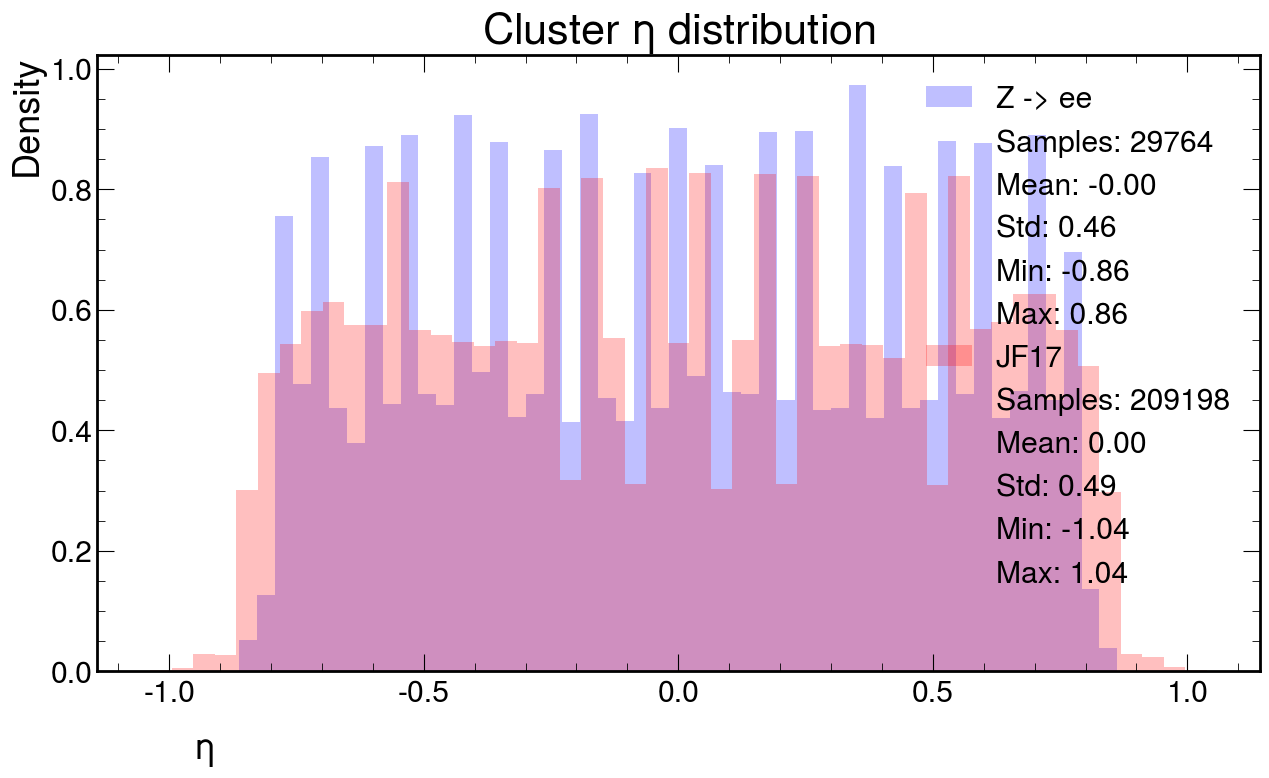

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cluster_eta'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$\eta$',
            ylabel='Density',
            title=r'Cluster $\eta$ distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(output_dir/'cluster_eta_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $\phi$

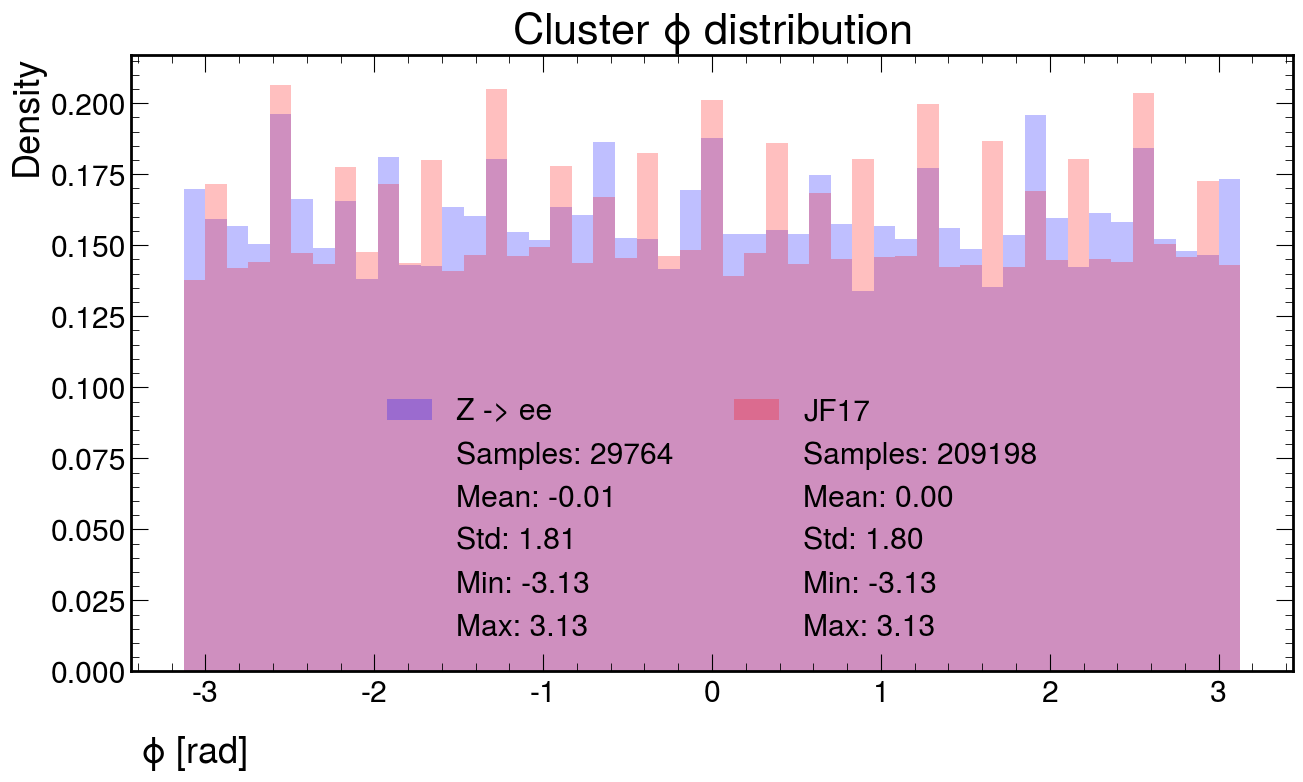

In [8]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cluster_phi'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$\phi$ [rad]',
            ylabel='Density',
            title=r'Cluster $\phi$ distribution',
        ),
        legend_kwargs=dict(
            loc='lower center',
            ncols=2
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(output_dir/'cluster_phi_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $E_{ratio}$

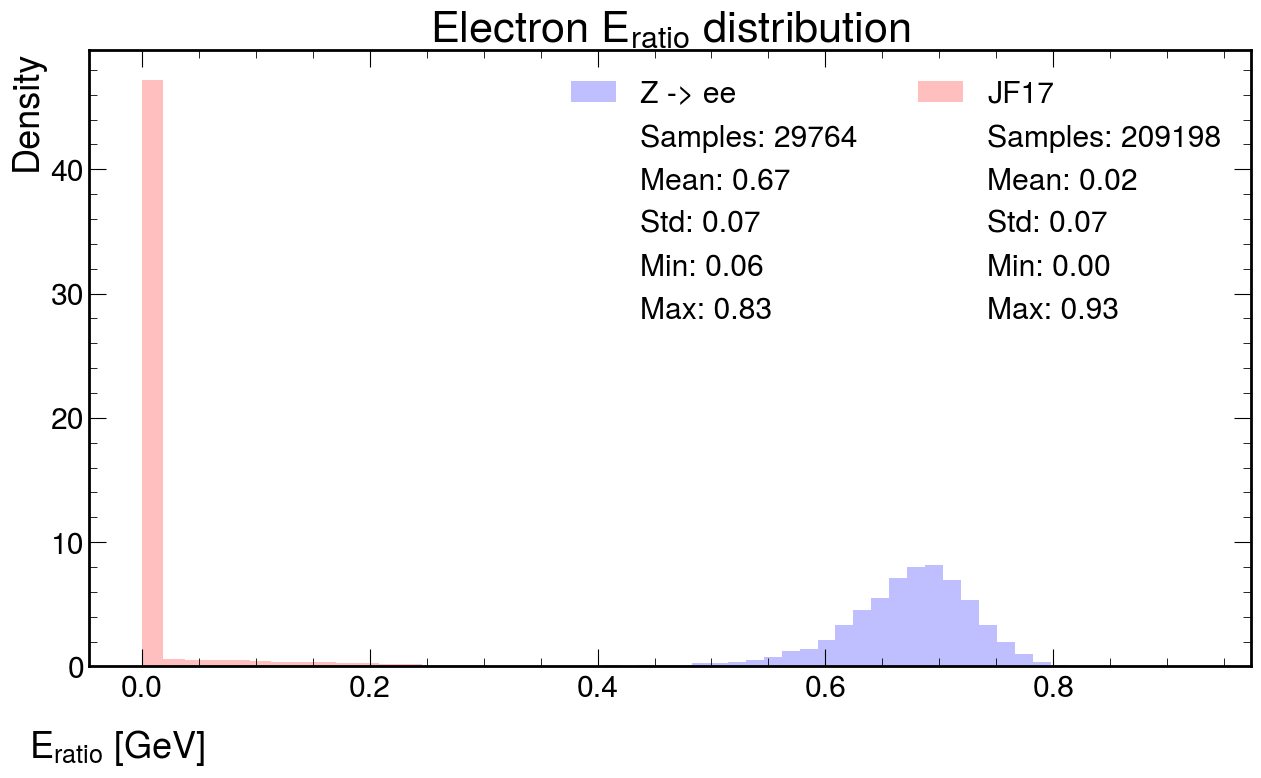

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cluster_eratio'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$E_{ratio}$ [GeV]',
            ylabel='Density',
            title=r'Electron $E_{ratio}$ distribution',
        ),
        legend_kwargs=dict(
            ncols=2
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(output_dir/'cluster_eratio_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $R_{had}$

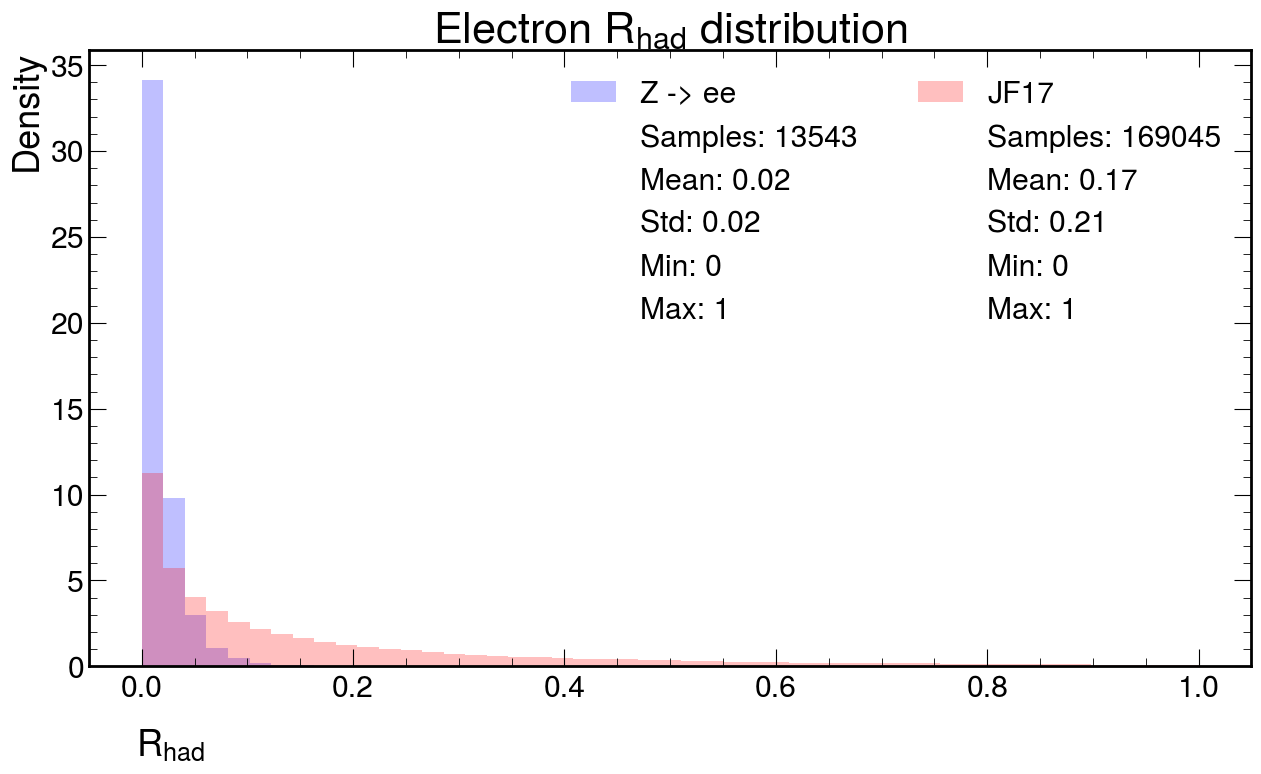

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    lplt.histplot(
        ds.ntuple_pdf['cluster_rhad'].dropna(),
        nbins=50,
        ax=ax,
        metrics=True,
        bin_max=1,
        bin_min=0,
        ax_set=dict(
            xlabel=r'$R_{had}$',
            ylabel='Density',
            title=r'Electron $R_{had}$ distribution',
        ),
        legend_kwargs=dict(
            ncols=2
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(output_dir/'cluster_rhad_distribution.png', bbox_inches='tight', dpi=300)

# Eletron $E_T$

Plotting zee-mb-2024-12-08...


KeyError: 'el_et'

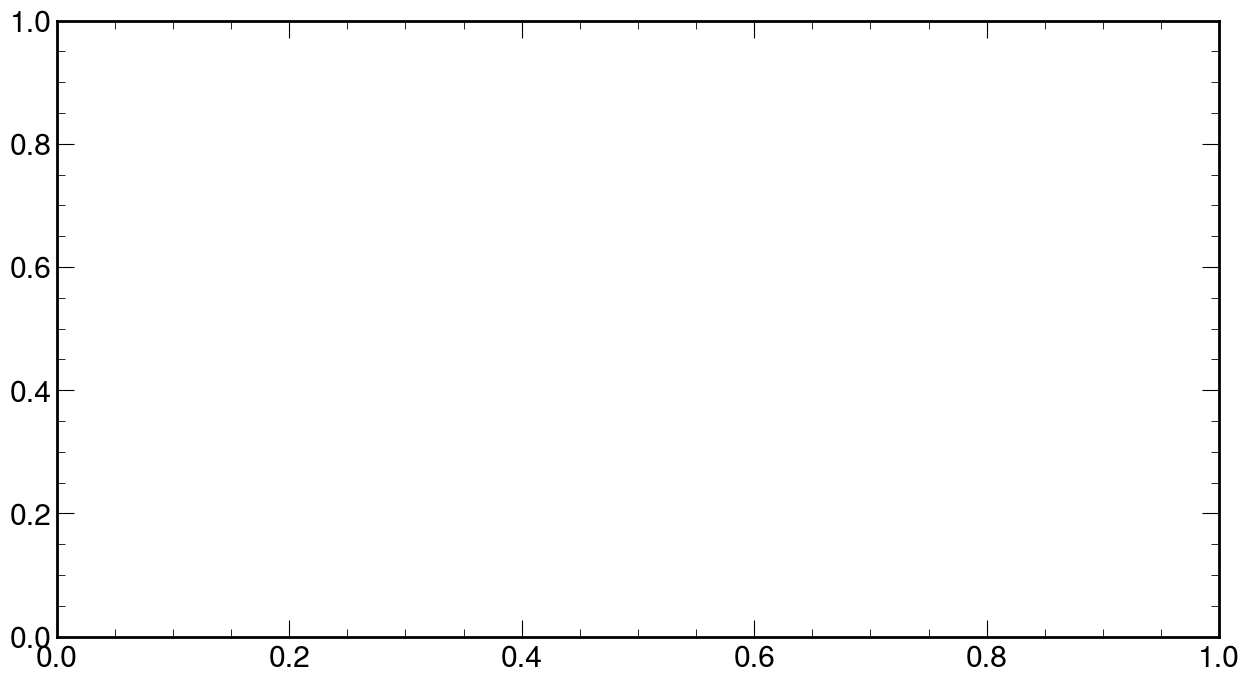

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, (ds_name, ds) in enumerate(datasets.items()):
    print(f'Plotting {ds_name}...')
    lplt.histplot(
        ds.ntuple_pdf['el_et'].dropna()/1000,
        nbins=50,
        ax=ax,
        metrics=True,
        ax_set=dict(
            xlabel=r'$E_T$ [GeV]',
            ylabel='Density',
            title=r'Electron $E_T$ distribution',
        ),
        legend_keargs=dict(
            ncols=2
        ),
        hist_kwargs=dict(
            histtype='step',
            label=ds.label,
            color=ds.color,
            density=True,
            alpha=0.25
        )
    )
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(output_dir/'electron_et_distribution.png', bbox_inches='tight', dpi=300)

# Eletron $\eta$

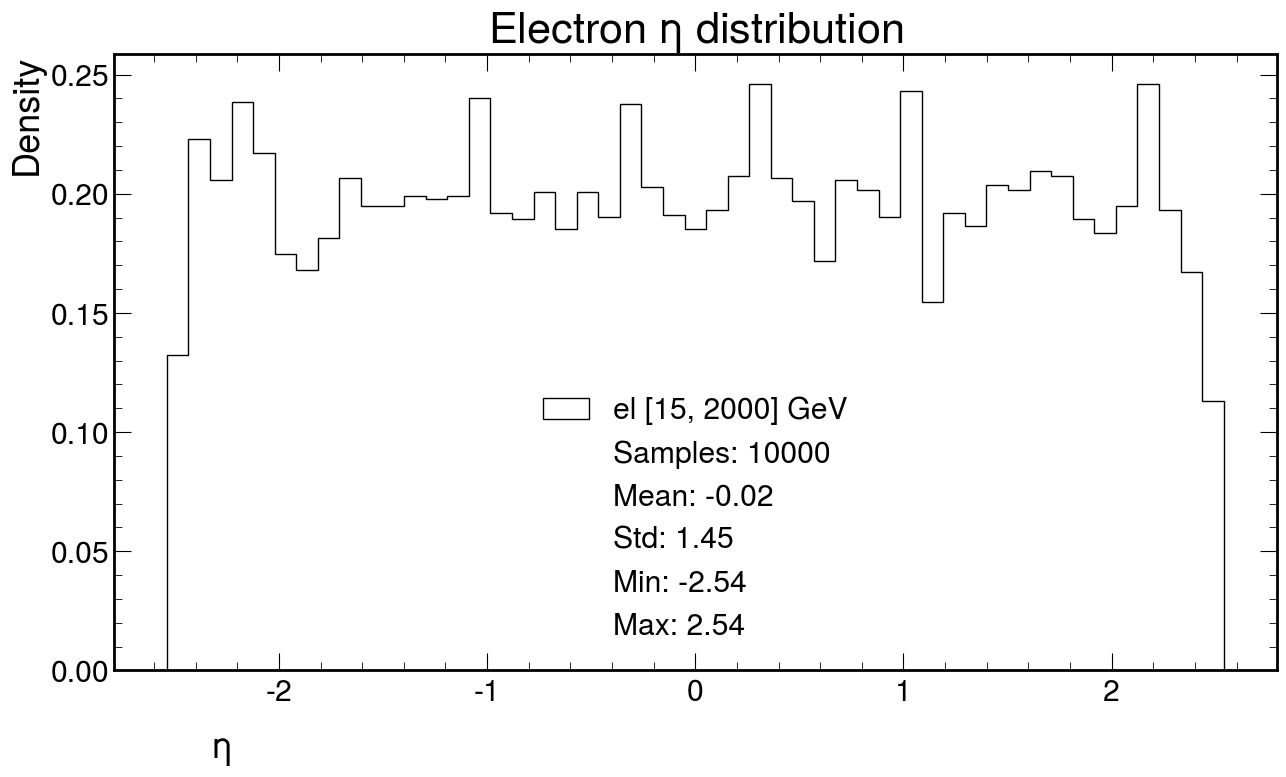

In [57]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['el_eta'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$\eta$',
        ylabel='Density',
        title=r'Electron $\eta$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(output_dir/'electron_eta_distribution.png', bbox_inches='tight', dpi=300)

# Eletron $\phi$

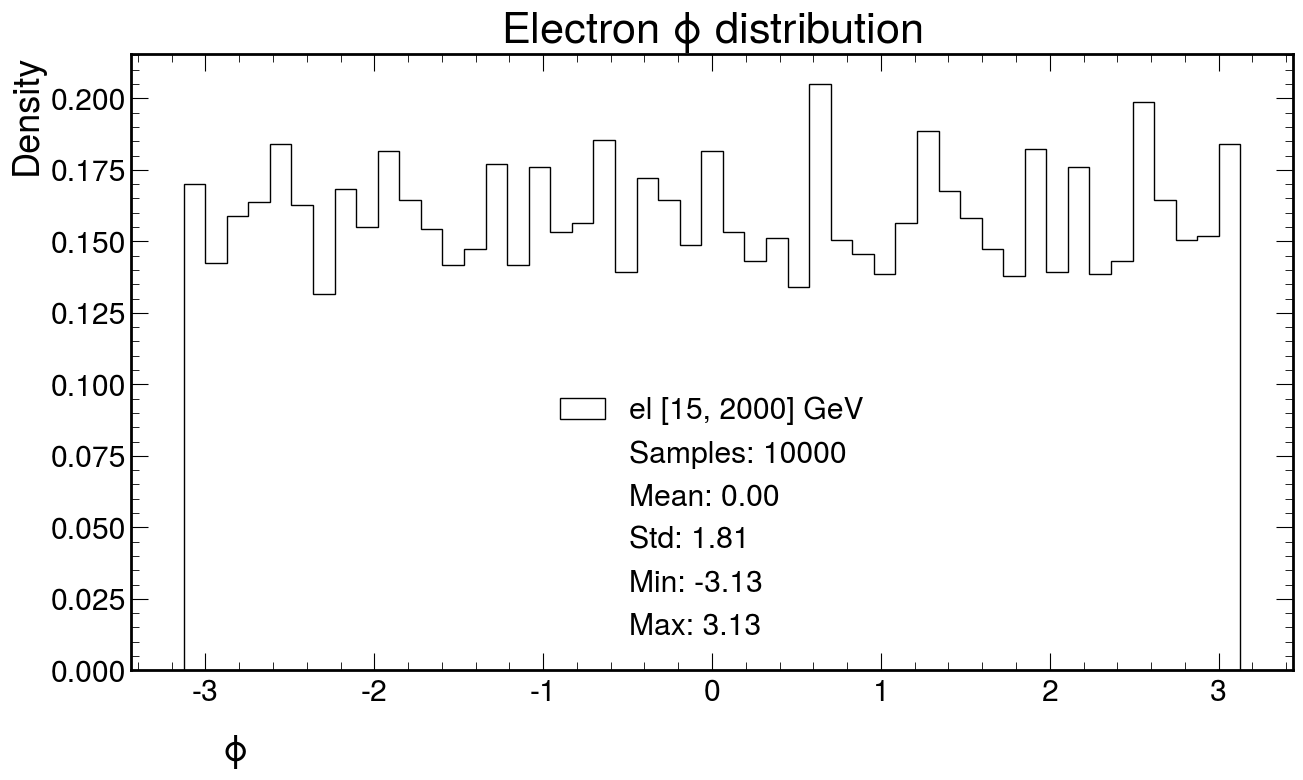

In [58]:
fig, ax = plt.subplots(figsize=(15, 8))
lplt.histplot(
    ntuple_pdf['el_phi'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel=r'$\phi$',
        ylabel='Density',
        title=r'Electron $\phi$ distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset.label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(output_dir/'electron_phi_distribution.png', bbox_inches='tight', dpi=300)